In [16]:
import os
import gc
import random
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.notebook import tqdm
from scipy.special import expit,logit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from torch.utils.data import DataLoader, Dataset, random_split

import cProfile
import pstats
from io import StringIO

# Load the dataset

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    for col in df.columns:  
        col_type = df[col].dtype  
        if col_type != object and str(col_type) != 'category':  
            c_min, c_max = df[col].min(), df[col].max()  
            if str(col_type)[:3] == 'int': 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32: 
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    # print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    # print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# Load the data
def sequential_data_loader(data_dir):
    for p_id in range(8,9):  # Loop through directories partition_id=3 to partition_id=9
        file_path = os.path.join(data_dir, f'partition_id={p_id}', 'part-0.parquet')
        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"Loading file: partition_id={p_id}")
        df = pl.read_parquet(file_path).to_pandas()

        # Create a new column with the suffix '_missing'
        for column in df.columns:
            df[f"{column}_missing"] = df[column].isnull().astype(np.int8)
        
        df = reduce_mem_usage(df,False)
        
        used_feature_names = [col for col in df.columns if col not in ['date_id', 'time_id', 'responder_6', 'weight','date_id_missing', 'time_id_missing', 'responder_6_missing', 'weight_missing']]
        target_name = 'responder_6'
        
        features = df[used_feature_names].values
        target = df[target_name].values
        # yield df, used_feature_names, features, target_name, target
        # del df, used_feature_names, features, target_name, target
        yield df, used_feature_names, target_name,p_id
        del df, used_feature_names, target_name, p_id
        gc.collect()

def interpolate_missing(initial_data):
    
    initial_data = initial_data.reset_index(drop=True)
    old_data = initial_data.copy()
    nan_indices = [i for i, val in enumerate(initial_data) if np.isnan(val)]
    missing_val_index = []
    
    if not nan_indices:
        print("No NaN values found in the dataset.")
        return
    else:
        start = nan_indices[0]
        # for i in range(1, len(nan_indices)):
        #     if nan_indices[i] != nan_indices[i - 1] + 1:
        #         missing_val_index.append([start, nan_indices[i - 1] + 1])
        #         start = nan_indices[i]
        # missing_val_index.append([start, nan_indices[-1] + 1])
        missing_val_index = np.split(nan_indices, np.where(np.diff(nan_indices) != 1)[0] + 1)
        missing_val_index = [[group[0], group[-1] + 1] for group in missing_val_index]
    missing_val_index = np.array(missing_val_index)
    # print(f"Discontinuity Matrix: \n{missing_val_index}")

    # find the index for which the weighted_mean has to be evaluated
    compute_index=[]
    prev_a = missing_val_index[0][0]
    prev_b = missing_val_index[0][1]
    for row in missing_val_index:
        a, b = row
        if (10 < a-prev_b):
            compute_index.append([prev_a,prev_b])
            prev_a = a
        prev_b = b
    compute_index.append([prev_a,prev_b])
    compute_index = np.array(compute_index)
    # print(f"Compute index: \n{compute_index}")
    #calculate the weighted mean only near the missing values
    global_valid_indices=[]
    global_weighted_mean = []
    for r in tqdm(compute_index, desc="Processing Missing Values"):
        point1, point2  = r
        # print(f'point1: {point1} | point2: {point2}')
        mod_start = max(point1-5,0)
        mod_end = min(point2+5, len(initial_data))
        # print(f'mod_start: {mod_start} | mod_end: {mod_end}')
        # NaN_index = [i for i in range(mod_start,mod_end) if np.isnan(initial_data.iloc[i])]
        NaN_index = initial_data.index[mod_start:mod_end][initial_data.iloc[mod_start:mod_end].isna()]
        NaN_index = np.array(NaN_index)
        # print(f"NaN_ Matrix: \n{NaN_index}")
        # step 0: calculate local missing val indexes
        local_missing_val_index = []
        if len(NaN_index) == 0:
            print("No NaN values found in the dataset.")
            return
        else:
            start = NaN_index[0]
            # for i in range(1, len(NaN_index)):
            #     if NaN_index[i] != NaN_index[i - 1] + 1:
            #         local_missing_val_index.append([start, NaN_index[i - 1] + 1])
            #         start = NaN_index[i]
            # local_missing_val_index.append([start, NaN_index[-1] + 1])
            local_missing_val_index = np.split(NaN_index, np.where(np.diff(NaN_index) != 1)[0] + 1)
            local_missing_val_index = [[group[0], group[-1] + 1] for group in local_missing_val_index]
        local_missing_val_index = np.array(local_missing_val_index)
        # print(f"local Discontinuity Matrix: \n{local_missing_val_index}")
        
        # Step 1: Remove NaN points to create a temporary set
        valid_values = [val for val in initial_data.iloc[mod_start:mod_end] if not np.isnan(val)]
        valid_indices = [i+mod_start for i in range(mod_end-mod_start) if not np.isnan(initial_data.iloc[i+mod_start])]# Indices of valid points
        global_valid_indices += (valid_indices)
        
        # Step 2: Compute weighted expanding mean on the valid values
        weighted_mean_valid = []
        for i in range(len(valid_values)):
            window = valid_values[max(0, i - 4):i + 1]  # Window size of 5
            weights = [0.5 if idx == len(window) - 1 else (0.5 / (len(window) - 1)) for idx in range(len(window))]
            current_mean = np.average(window, weights=weights)
            weighted_mean_valid.append(current_mean)
        global_weighted_mean += (weighted_mean_valid)
        # print(f"\n{valid_indices} -> \n{weighted_mean_valid}")
        
        # Step 3: Handle each missing range in the discontinuity matrix
        dif = 0
        for row in local_missing_val_index:
            a, b = row
            # print(f" a: {a} | b : {b}")
            approx_values = []
            if a == 0:  # Handle edge case for missing values at the start
                for i in range(a, b):
                    # Use the first expanding mean value
                    approx_values.append(weighted_mean_valid[0])
            else:
                start_index = a - 1 - dif - mod_start# Last valid index before the missing range
                end_index = b - dif -mod_start # First valid index after the missing range
                # print(f"weights' start: {start_index} | end : {end_index}")
                for i in range(a, b):
                    ratio = (i - a+1) / (b - a+1)
                    if len(initial_data) == b:
                        end_index = b - 1 - dif
                    interpolated_value = (1 - ratio) * weighted_mean_valid[start_index] + ratio * weighted_mean_valid[end_index - (b-a)] # (end index - num_nan_indexes) = end_index-(b-a)
                    # print(f"weights' start: {start_index} -> {weighted_mean_valid[start_index]}| end : {end_index} -> {weighted_mean_valid[end_index - (b-a)]} | interpolated : {interpolated_value}")
                    approx_values.append(interpolated_value)
            initial_data.iloc[a:b] = approx_values
            dif += (b-a)
            
    plt.figure(figsize=(12, 8), facecolor = "black")
    plt.plot(range(len(initial_data)), initial_data, label="predicted Values (Original Data)", color="yellow", linestyle="-", alpha=0.3)
    plt.plot(range(len(initial_data)), old_data, label="Real Values (Original Data)", color="red", linestyle="-", alpha=0.7)
    # plt.plot(range(len(initial_data)), initial_data.mean(), label="Dataset with Approximated Values", marker="o", linestyle="-", alpha=0.7)
    plt.plot(global_valid_indices, global_weighted_mean, label="Weighted Expanding Mean", color="green", linestyle="--", alpha=1.0)
    # Access current axes and set its background color
    ax = plt.gca()
    ax.set_facecolor('black')  # Change to any color you like
    plt.title("Dataset with Approximated Values, Real Values, and Weighted Expanding Mean")
    plt.xlabel("Index (Original Data)")
    plt.ylabel("Values")
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.legend()
    plt.grid(True)
    plt.show()
    return initial_data

# # Dataset and DataLoader setup for PyTorch
# class TimeSeriesDataset(Dataset):
#     def __init__(self, data, used_feature_names, target_name):
#         self.features = data[used_feature_names].values
#         self.targets = data[target_name].values
#         self.weights = data['weight'].values

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         x = self.features[idx]
#         y = self.targets[idx]
#         w = self.weights[idx]
#         return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(w, dtype=torch.float32)

# # Define the TimeXer model
# class TimeXer(nn.Module):
#     def __init__(self, input_dim, projected_dim, hidden_dim, num_layers, output_dim):
#         super(TimeXer, self).__init__()
#         self.projection = nn.Linear(input_dim, projected_dim)
#         self.dropout = nn.Dropout(p=0.1)
#         self.transformer_layer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=projected_dim, nhead=4, dim_feedforward=hidden_dim, batch_first=True),
#             num_layers=num_layers
#         )
#         self.fc = nn.Linear(projected_dim, output_dim)

#     def forward(self, x):
#         x = self.projection(x)
#         x = self.dropout(x)
#         x = self.transformer_layer(x)
#         x = self.fc(x)
#         return x

data_dir = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet'
output_df = '/kaggle/working/processed_data/'

Loading file: partition_id=8
Memory usage of dataframe is 2605.73 MB
176
partially null columns:  feature_08


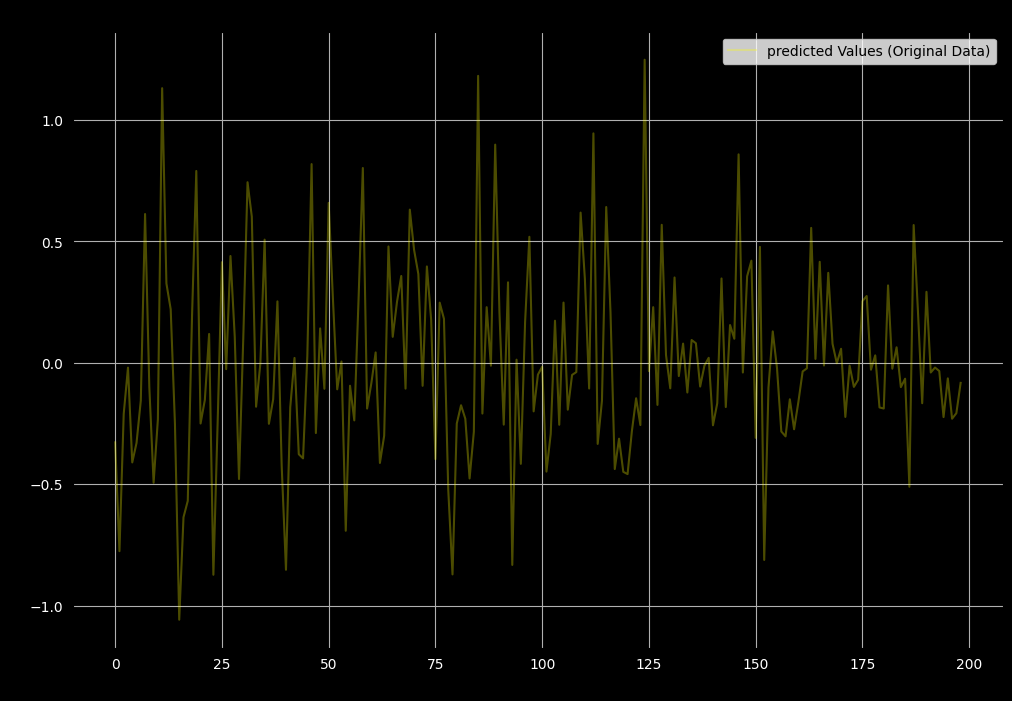

In [21]:
# Identify indices with NaN values in the original dataset
for df,features,target_name,p_id in sequential_data_loader(data_dir):
    # print('fully null columns: ', df.columns[df.isnull().all()].tolist())
    print(len(features))
    print('partially null columns: ', df.columns[df.isnull().any()].tolist()[0])
    # for i in df.columns[df.isnull().any()].tolist()[0:1]:
    #     print(f"{i}")  
    #     df[target_name][637000:637100] = interpolate_missing(df[i][637000:637100])
    # output_path = f'{output_df}/partition_id={p_id}'
    # os.makedirs(output_path, exist_ok=True)
    # df.to_parquet(f'{output_path}/part_0.parquet',index=False)
    
    initial_data = df[target_name][-200:-1]
    initial_data.to_csv('/kaggle/working/predictions_08_100.csv', index=False)
    plt.figure(figsize=(12, 8), facecolor = "black")
    plt.plot(range(len(initial_data)), initial_data, label="predicted Values (Original Data)", color="yellow", linestyle="-", alpha=0.3)
    # Access current axes and set its background color
    ax = plt.gca()
    ax.set_facecolor('black')  # Change to any color you like
    plt.title("Dataset with Approximated Values, Real Values, and Weighted Expanding Mean")
    plt.xlabel("Index (Original Data)")
    plt.ylabel("Values")
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.legend()
    plt.grid(True)
    plt.show()